## EDSA Movie Recommendation Predict ##

This notebook is used to build a Movie recommendation model to predict movie rating for different users and movies

**Steps followed in notebook**

1. Import all libraries (data cleaning, preprocesing, EDA, models, cross validation, evaluation).
2. Import datasets
3. Data cleaning and data preprocessing
4. Exploratory data analysis "EDA"
6. Model building and comparison
7. Model hyperparameter tuning
8. Models Metrics evaluation
9. Final model creation
10. Save model for reproducability

## Imports libraries and packages ##

In [157]:
#import libraries for operating system
import os
#import libraries for data processing
import pandas as pd
import numpy as np
import re
#import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import surprise data preprocessors
from surprise import Reader
from surprise import Dataset
#import surprise Models
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import CoClustering
from surprise import BaselineOnly
from surprise import NormalPredictor

#import model evaluation libraries
from surprise.model_selection import cross_validate

#import Hyperparameter tuning libraries
from surprise.model_selection import GridSearchCV

#import recommendation system library to predict ratings
from reco_utils.recommender.surprise.surprise_utils import predict
#import recommendation system library to evaluate predicted ratings
from reco_utils.evaluation.python_evaluation import (rmse,mae)
#save and load model packages
import pickle

In [158]:
#display all files in folder
os.listdir()

['.ipynb_checkpoints',
 'EDSA Movie Recommendation Predict.ipynb',
 'genome_scores.csv',
 'genome_tags.csv',
 'imdb_data.csv',
 'links.csv',
 'movies.csv',
 'results.xlsx',
 'results_BaselineOnly.xlsx',
 'results_BaselineOnly_als.xlsx',
 'results_BaselineOnly_sgd.xlsx',
 'sample_submission.csv',
 'SVDpp Rating submission.csv',
 'SVDpp.pkl',
 'tags.csv',
 'test.csv',
 'train.csv']

## Import datasets ##

In [159]:
#load all predict files
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
sample_submission = pd.read_csv('sample_submission.csv')
tags = pd.read_csv('tags.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

## Data cleaning and data preprocessing ##

In [160]:
#iterate through each file and show info for all datasets, 
#identify empty cells, display top 2 observations and provide 5 summary statistics for each dataset
file_names = ['genome_scores', 'genome_tags', 'imdb_data', 'links', 'movies', 'sample_submission', 'tags', 'test', 'train']
files = [genome_scores, genome_tags, imdb_data, links, movies, sample_submission, tags, test, train]
for name, file in zip(file_names,files):
    print(name)
    print("")
    print(file.info())
    print("")
    print("Is null?")
    print(file.isnull().sum())
    print("")
    print(file.head(2))
    print("")
    print(file.describe())
    print("\n\n------------------------------------------\n\n")

genome_scores

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB
None

Is null?
movieId      0
tagId        0
relevance    0
dtype: int64

   movieId  tagId  relevance
0        1      1    0.02875
1        1      2    0.02375

            movieId         tagId     relevance
count  1.558445e+07  1.558445e+07  1.558445e+07
mean   4.602249e+04  5.645000e+02  1.163679e-01
std    5.535221e+04  3.256254e+02  1.544722e-01
min    1.000000e+00  1.000000e+00  2.500000e-04
25%    3.853750e+03  2.827500e+02  2.400000e-02
50%    8.575500e+03  5.645000e+02  5.650000e-02
75%    8.018650e+04  8.462500e+02  1.407500e-01
max    2.064990e+05  1.128000e+03  1.000000e+00


------------------------------------------


genome_tags

<class 'pandas.core.frame.DataFrame'>
RangeIn

***Notes of empty cells and EDA***: 

**imdb_data empty cells:**

title_cast       object, 
director          object, 
runtime          float64, 
budget           object, 
plot_keywords    object, 

**Links empty cells:**

tmdbId           float

**Tags empty cells:**

tag object, 

**train**

Look at distibution of rating

In [161]:
#fill all empty cells of imdb_data with relevant data type
imdb_data['title_cast'] = imdb_data['title_cast'].fillna('')
imdb_data['director'] = imdb_data['director'].fillna('')
imdb_data['runtime'] = imdb_data['runtime'].fillna(0)
imdb_data['budget'] = imdb_data['budget'].fillna('')
imdb_data['plot_keywords'] = imdb_data['plot_keywords'].fillna('')
#fill all empty cells of links with relevant data type
links['tmdbId'] = links['tmdbId'].fillna(0)
#fill all empty cells of tags with relevant data type
tags['tag'] = tags['tag'].fillna('')

In [162]:
#split all genres
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x.split('|')))
#extract the year of all movies from title
movies['year'] = movies['title'].apply(lambda x: re.findall(r'\((.[\d]+)\)',x))
movies['year'] = movies['year'].str[-1]
movies['year'] = movies['year'].fillna(0)
movies['year'] = movies['year'].astype('int')
#split all titles
movies['title_new'] = movies['title'].apply(lambda x: x.split('('))
movies['title_new'] = movies['title_new'].apply(lambda x: x[0])
movies.head()

,movieId,title,genres,year,title_new
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,Toy Story
1,2,Jumanji (1995),Adventure Children Fantasy,1995,Jumanji
2,3,Grumpier Old Men (1995),Comedy Romance,1995,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy Drama Romance,1995,Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,1995,Father of the Bride Part II


In [163]:
#split all title_cast in imdb_data
imdb_data['title_cast'] = imdb_data['title_cast'].apply(lambda x: ' '.join(x.split('|')))
#split all plot_keywords in imdb_data
imdb_data['plot_keywords'] = imdb_data['plot_keywords'].apply(lambda x: ' '.join(x.split('|')))

In [164]:
#confirm data cleaned
imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks Tim Allen Don Rickles Jim Varney Wal...,John Lasseter,81.0,"$30,000,000",toy rivalry cowboy cgi animation
1,2,Robin Williams Jonathan Hyde Kirsten Dunst Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game adventurer fight game
2,3,Walter Matthau Jack Lemmon Sophia Loren Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat lake neighbor rivalry
3,4,Whitney Houston Angela Bassett Loretta Devine ...,Terry McMillan,124.0,"$16,000,000",black american husband wife relationship betra...
4,5,Steve Martin Diane Keaton Martin Short Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood doberman dog mansion


## EDA: Exploratory Data Analysis ##

In [165]:
#create copy of training data for merge
merged_df = train.copy()
#merge movies dataframe to training dataframe
merged_df = merged_df.merge(movies, how='left', on='movieId')
#merge movies dataframe to training dataframe
merged_df = merged_df.merge(imdb_data, how='left', on='movieId')

#confirm number of columns and rows
print(merged_df.shape)

(10000038, 13)


In [166]:
#view first 5 rows of train data
merged_df.head()

,userId,movieId,rating,timestamp,title,genres,year,title_new,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy Crime Drama Thriller,2008,In Bruges,Elizabeth Berrington Rudy Blomme Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf bruges irish hitman
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,1995,Father of the Bride Part II,Steve Martin Diane Keaton Martin Short Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood doberman dog mansion
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action Comedy Sci-Fi,2002,Men in Black II,Tommy Lee Jones Will Smith Rip Torn Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie michael jackson character shorthaired...
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure Comedy Crime,2005,Miss Congeniality 2: Armed and Fabulous,Sandra Bullock Regina King Enrique Murciano Wi...,Marc Lawrence,115.0,"$45,000,000",female protagonist cleave gag good woman fbi
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama Horror Mystery Thriller,1994,Wes Craven's New Nightmare,Jeff Davis Heather Langenkamp Miko Hughes Matt...,Wes Craven,112.0,"$8,000,000",freddy krueger elm street famous director as h...


In [167]:
#confirm merged data datatypes
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000038 entries, 0 to 10000037
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   userId         int64  
 1   movieId        int64  
 2   rating         float64
 3   timestamp      int64  
 4   title          object 
 5   genres         object 
 6   year           int32  
 7   title_new      object 
 8   title_cast     object 
 9   director       object 
 10  runtime        float64
 11  budget         object 
 12  plot_keywords  object 
dtypes: float64(2), int32(1), int64(3), object(7)
memory usage: 1.0+ GB


In [168]:
#confirm descriptive statistics numeric columns
print(merged_df[['rating','timestamp','year','runtime']].describe())

             rating     timestamp          year       runtime
count  1.000004e+07  1.000004e+07  1.000004e+07  9.633031e+06
mean   3.533395e+00  1.215677e+09  1.993346e+03  8.412204e+01
std    1.061124e+00  2.268921e+08  4.596961e+01  5.577055e+01
min    5.000000e-01  7.896520e+08  0.000000e+00  0.000000e+00
25%    3.000000e+00  1.011742e+09  1.990000e+03  0.000000e+00
50%    3.500000e+00  1.199019e+09  1.997000e+03  1.030000e+02
75%    4.000000e+00  1.447242e+09  2.003000e+03  1.220000e+02
max    5.000000e+00  1.574328e+09  2.019000e+03  8.770000e+02


C:\Users\jeanj\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

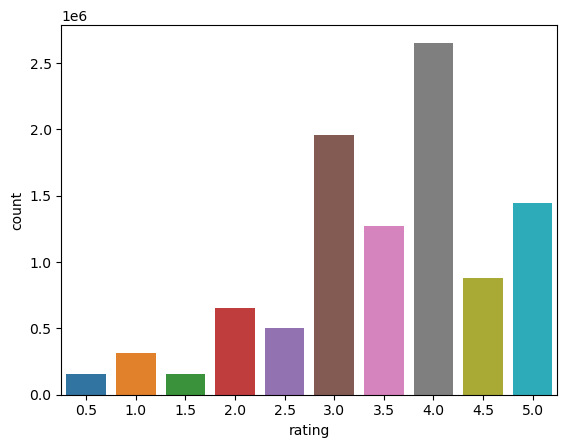

In [169]:
#rating distribution
sns.countplot(merged_df['rating'])

<AxesSubplot:xlabel='count', ylabel='year'>

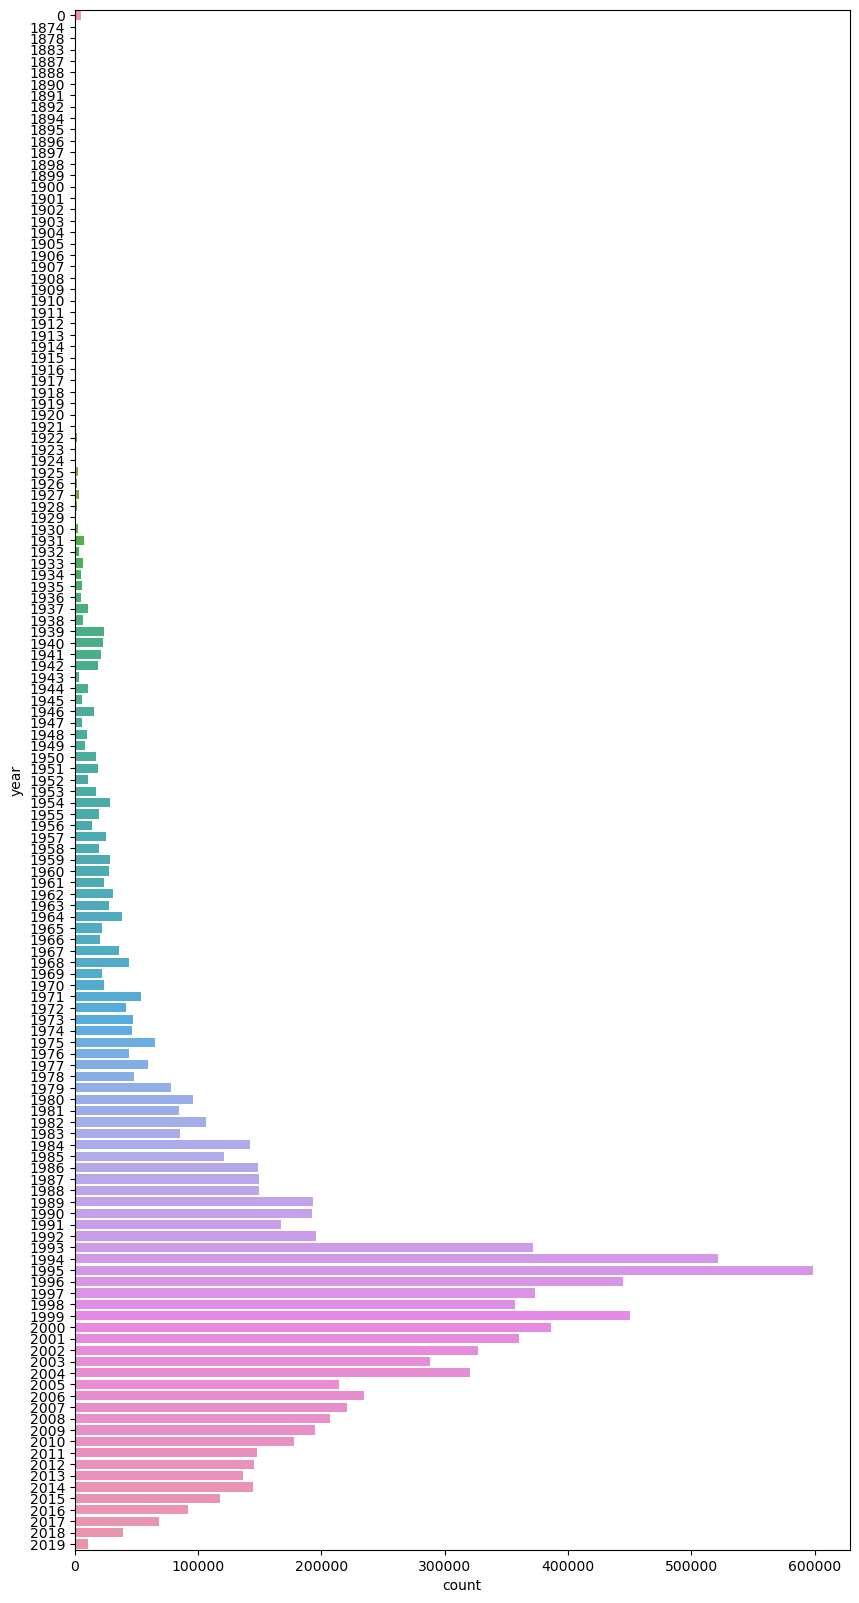

In [170]:
#year distribution
fig , ax = plt.subplots(figsize=(10,20))
sns.countplot(y=merged_df['year'])

In [171]:
#Most votes per director Top 20
directors = merged_df['director'].value_counts()
directors[:20]

                      2602688
Quentin Tarantino      109919
Michael Crichton        65157
J.R.R. Tolkien          62963
Lilly Wachowski         60988
Stephen King            59903
Ethan Coen              51185
James Cameron           51178
Luc Besson              44015
Jonathan Nolan          42645
Thomas Harris           36425
M. Night Shyamalan      35567
Steven Spielberg        35236
Dean Devlin             35157
Bob Kane                35129
Jonathan Hensleigh      33106
Andrew Niccol           32868
Christopher Nolan       32633
Winston Groom           32383
Kevin Smith             32075
Name: director, dtype: int64

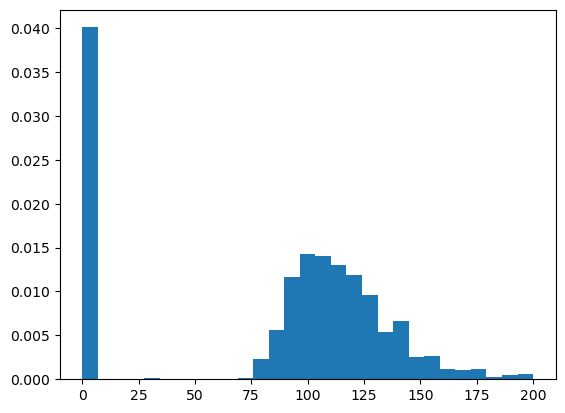

In [172]:
#runtime distribution
plt.hist(merged_df['runtime'],density=True,orientation='vertical', bins=np.linspace(0,200,30))
plt.show()

In [173]:
#Most rated movies
movies_rate_count = merged_df['title_new'].value_counts()
movies_rate_count[:20]

Shawshank Redemption, The                              32831
Forrest Gump                                           32383
Pulp Fiction                                           31697
Silence of the Lambs, The                              29444
Matrix, The                                            29014
Star Wars: Episode IV - A New Hope                     27560
Jurassic Park                                          25518
Schindler's List                                       24004
Braveheart                                             23722
Fight Club                                             23536
Terminator 2: Judgment Day                             23075
Toy Story                                              23062
Star Wars: Episode V - The Empire Strikes Back         22956
Lord of the Rings: The Fellowship of the Ring, The     22216
Usual Suspects, The                                    22032
Raiders of the Lost Ark                                21982
Star Wars: Episode VI - 

In [174]:
#display training data sample data
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [175]:
#identify training data columns and row amounts
print(fr'Amount of data rows: {train.shape[0]}')
print(fr'Amount of data columns: {train.shape[1]}')

Amount of data rows: 10000038
Amount of data columns: 4


In [176]:
#total unique users
print(fr"Amount of users voted in training dataset: {train['userId'].nunique()}")

Amount of users voted in training dataset: 162541


In [177]:
#total unique movies in training data set
print(fr"Amount of movies in training dataset: {train['movieId'].nunique()}")

Amount of movies in training dataset: 48213


<AxesSubplot:xlabel='rating', ylabel='count'>

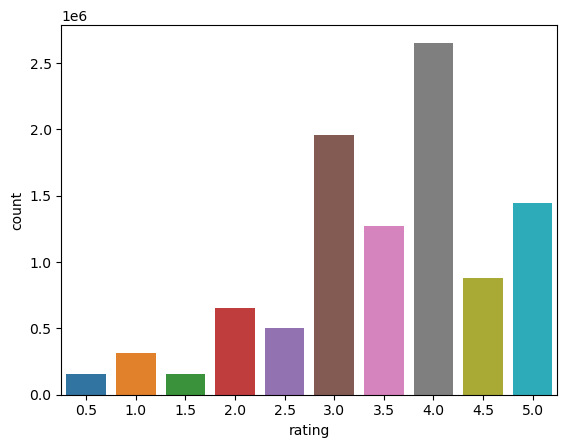

In [178]:
#display rating distribution for training dataset
sns.countplot(x=train['rating'])

<AxesSubplot:>

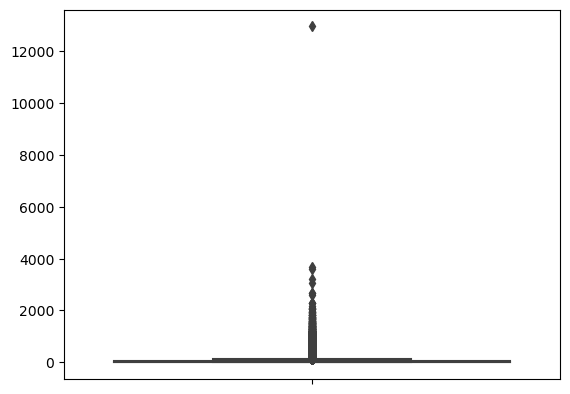

In [179]:
#identify outliers in dataset
sns.boxplot(y=train['userId'].value_counts().values)

In [180]:
#descriptive statistics of user vote count
train['userId'].value_counts().describe()

count    162541.000000
mean         61.523173
std         107.410889
min           1.000000
25%          14.000000
50%          28.000000
75%          65.000000
max       12952.000000
Name: userId, dtype: float64

In [181]:
#display amount of votes per user descending order (display highest amount of votes)
train['userId'].value_counts()

72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
          ...  
127098        1
121071        1
55362         1
105714        1
79087         1
Name: userId, Length: 162541, dtype: int64

In [182]:
#assign outlier user vote amount to variable
outlying_user = train['userId'].value_counts()
print(f'Outlying user information \n\nuserId:{outlying_user.index[0]} VoteCount:{outlying_user.iloc[0]}')

Outlying user information 

userId:72315 VoteCount:12952


In [183]:
#assign total count of votes per user to variable
count_user_vote = train['userId'].value_counts()
#remove index from series
count_user_vote = count_user_vote.reset_index()
#rename count_user_vote columns
count_user_vote.columns = ['userId','VoteCount']
#filter and list all users lower than outlier user
count_user_vote = count_user_vote[count_user_vote['VoteCount']<12952]
count_user_vote = list(count_user_vote['userId'])
#create new training dataset excluding the outlier user
train = train[train['userId'].isin(count_user_vote)]
print(train.shape)
print(train.head())

(9987086, 4)
   userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539
3  106362    32296     2.0  1423042565
4    9041      366     3.0   833375837


## Model building and comparison ##

**Models to test**

1. SVD
2. SVDpp
3. NMF
4. SlopeOne
5. KNNBasic
6. KNNBaseline
7. KNNWithMeans
8. KNNWithZScore
9. CoClustering
10. BaselineOnly
11. NormalPredictor

In [184]:
#create copy of train dataset and remove timestamp column
model_data = train.drop(['timestamp'],axis=1)
model_data

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0
...,...,...,...
10000033,136395,99114,5.0
10000034,140078,553,3.0
10000035,154807,56782,4.0
10000036,85805,327,4.0


In [185]:
#check for empty cells in training data
model_data.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

**All models excluding KNN models**

KNN models took to long to fit

In [61]:
#parse training data and identify minimum and maximum rating
reader = Reader(rating_scale=(min(model_data['rating']),max(model_data['rating'])))
#load data from DataFrame
model_train = Dataset.load_from_df(model_data.sample(frac=0.10,random_state=42),reader)
#empty list to capture model results
results = []
#model names for iteration
model_names = ['SVD',
               'SVDpp','NMF',
               'SlopeOne','CoClustering',
               'BaselineOnly','NormalPredictor']
#model instances for iteration
model_instances = [SVD(),
                   SVDpp(),NMF(),
                   SlopeOne(),CoClustering(),
                   BaselineOnly(),NormalPredictor()]
#iteration of model name and instances to calculate RMSE for model through cross validation
for name, model in zip(model_names, model_instances):
    result = cross_validate(model, model_train, measures=['RMSE'],cv=3,verbose=False)
    result_prep = pd.DataFrame(result).mean(axis=0)
    result_prep['model'] = name
    results.append(result_prep)
    print(fr"Model completed: {name}")
#display results from sorting by best test_rmse  
print(pd.DataFrame(results).set_index('model').sort_values('test_rmse'))

Model completed: SVD
Model completed: SVDpp
Model completed: NMF
Model completed: SlopeOne
Model completed: CoClustering
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Model completed: BaselineOnly
Model completed: NormalPredictor
                 test_rmse   fit_time  test_time
model                                           
BaselineOnly      0.915912   3.527174   3.644971
SVDpp             0.916778  18.027840  11.053222
SVD               0.921740   8.928425   5.808890
CoClustering      1.029270  27.814526   3.908630
NMF               1.043548  18.623207   3.714634
SlopeOne          1.075998   9.042431   9.694093
NormalPredictor   1.447979   1.144964   2.452809


**SVDpp & BaselineOnly models with higher amount of data**

In [62]:
#parse training data and identify minimum and maximum rating
reader = Reader(rating_scale=(min(model_data['rating']),max(model_data['rating'])))
#load data from DataFrame
model_train = Dataset.load_from_df(model_data.sample(frac=0.30,random_state=42),reader)
#empty list to capture model results
results = []
#model names for iteration
model_names = ['SVDpp',
               'BaselineOnly']
#model instances for iteration
model_instances = [SVDpp(),
                   BaselineOnly()]
#iteration of model name and instances to calculate RMSE for model through cross validation
for name, model in zip(model_names, model_instances):
    result = cross_validate(model, model_train, measures=['RMSE'],cv=3,verbose=False)
    result_prep = pd.DataFrame(result).mean(axis=0)
    result_prep['model'] = name
    results.append(result_prep)
    print(fr"Model completed: {name}")
#display results from sorting by best test_rmse  
print(pd.DataFrame(results).set_index('model').sort_values('test_rmse'))

Model completed: SVDpp
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Model completed: BaselineOnly
              test_rmse    fit_time  test_time
model                                         
SVDpp          0.879168  131.615084  56.774370
BaselineOnly   0.888716   12.003450  10.575098


## Model hyperparameter tuning ##

**Hyperparameter Tuning for SVDpp model**

In [63]:
#create copy of model data for grid search
grid_data = model_data.sample(n=1000000)
#parse training data and identify minimum and maximum rating
reader = Reader(rating_scale=(min(grid_data['rating']),max(grid_data['rating'])))
#load data from DataFrame
data = Dataset.load_from_df(grid_data[['userId','movieId','rating']], reader)
#create parameter grid for gridsearch
parameter_grid = {'n_factors': [1],'n_epochs': [20],'init_std_dev':[0.01],'lr_all':[0.0075],'reg_all':[0.007]}
#perform grid search
gridsearch = GridSearchCV(algo_class=SVDpp, param_grid= parameter_grid,cv=5,return_train_measures=True)
gridsearch.fit(data)
#save gridsearch results
results = pd.DataFrame(gridsearch.cv_results)
results = results[['mean_test_rmse','std_test_rmse','mean_train_rmse','std_train_rmse','rank_test_rmse','mean_fit_time','std_fit_time','mean_test_time','std_test_time','params']]
results.sort_values('mean_test_rmse')

,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params
0,0.899217,0.000807,0.813071,0.001245,1,9.928379,0.029144,6.346866,1.534199,"{'n_factors': 1, 'n_epochs': 20, 'init_std_dev..."


**Hyperparameter Tuning for BaselineOnly model with method als**

In [64]:
#create copy of model data for grid search
grid_data = model_data.sample(n=1000000)
#parse training data and identify minimum and maximum rating
reader = Reader(rating_scale=(min(grid_data['rating']),max(grid_data['rating'])))
#load data from DataFrame
data = Dataset.load_from_df(grid_data[['userId','movieId','rating']], reader)
#create parameter grid for gridsearch
#'reg_i':[1,5,10,15],'reg_u':[5,10,15,20],'n_epochs':[1,5,10,15]
parameter_grid = {'bsl_options':{'method':['als'],'reg_i':[5],'reg_u':[4],'n_epochs':[19]}}
#perform grid search
gridsearch = GridSearchCV(algo_class=BaselineOnly, param_grid= parameter_grid,cv=5,return_train_measures=True)
gridsearch.fit(data)
#save gridsearch results
results = pd.DataFrame(gridsearch.cv_results)
results = results[['mean_test_rmse','std_test_rmse','mean_train_rmse','std_train_rmse','rank_test_rmse','mean_fit_time','std_fit_time','mean_test_time','std_test_time','params']]
results.sort_values('mean_test_rmse')

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params
0,0.899889,0.001258,0.81507,0.000276,1,7.082615,0.105638,0.655448,0.005004,"{'bsl_options': {'method': 'als', 'reg_i': 5, ..."


**Hyperparameter Tuning for BaselineOnly model with method sgd**

In [65]:
#create copy of model data for grid search
grid_data = model_data.sample(n=1000000)
#parse training data and identify minimum and maximum rating
reader = Reader(rating_scale=(min(grid_data['rating']),max(grid_data['rating'])))
#load data from DataFrame
data = Dataset.load_from_df(grid_data[['userId','movieId','rating']], reader)
#create parameter grid for gridsearch
#,'learning_rate':[0.001,0.005,0.010,0.05],'n_epochs':[1,10,20,25]
parameter_grid = {'bsl_options':{'method':['sgd'],'reg':[0.001],'learning_rate':[0.007],'n_epochs':[22]}}
#perform grid search
gridsearch = GridSearchCV(algo_class=BaselineOnly, param_grid= parameter_grid,cv=5,return_train_measures=True)
gridsearch.fit(data)
#save gridsearch results
results = pd.DataFrame(gridsearch.cv_results)
results = results[['mean_test_rmse','std_test_rmse','mean_train_rmse','std_train_rmse','rank_test_rmse','mean_fit_time','std_fit_time','mean_test_time','std_test_time','params']]
results.sort_values('mean_test_rmse')

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...


,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params
0,0.899181,0.001092,0.817553,0.000366,1,5.523677,0.228008,2.026397,1.65764,"{'bsl_options': {'method': 'sgd', 'reg': 0.001..."


## Models Metrics evaluation ##

**Using Cross Validation to determine best performing models: Normal vs Hyperparameter tuned models**

In [66]:
#parse training data and identify minimum and maximum rating
reader = Reader(rating_scale=(min(model_data['rating']),max(model_data['rating'])))
#load data from DataFrame
model_train = Dataset.load_from_df(model_data.sample(frac=0.30,random_state=42),reader)
#empty list to capture model results
results = []
#model names for iteration
model_names = ['SVDpp',
               'BaselineOnly','SVDpp_hyper',
               'BaselineOnly_als','BaselineOnly_sgd']
#model instances for iteration
model_instances = [SVDpp(),
                   BaselineOnly(),
                   SVDpp(n_factors=1, n_epochs=20, init_std_dev=0.01, lr_all=0.0075,reg_all=0.007),
                  BaselineOnly(bsl_options={'method':'als','reg_i':5,'reg_u':4,'n_epochs':19}),
                  BaselineOnly(bsl_options={'method':'sgd','reg':0.001,'learning_rate':0.007,'n_epochs':22})]
#iteration of model name and instances to calculate RMSE for model through cross validation
for name, model in zip(model_names, model_instances):
    result = cross_validate(model, model_train, measures=['RMSE'],cv=5,verbose=False)
    result_prep = pd.DataFrame(result).mean(axis=0)
    result_prep['model'] = name
    results.append(result_prep)
    print(fr"Model completed: {name}")
#display results from sorting by best test_rmse      
print(pd.DataFrame(results).set_index('model').sort_values('test_rmse'))

Model completed: SVDpp
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Model completed: BaselineOnly
Model completed: SVDpp_hyper
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Model completed: BaselineOnly_als
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Model completed: BaselineOnly_sgd
                  test_rmse    fit_time  test_time
model                                             
SVDpp_hyper        0.868711   60.801941  36.790281
SVDpp              0.872158  178.093541  39.001527
BaselineOnly_als   0.878207   24.988228   6.709462
BaselineOnly_sgd   0.881294   17.403942   6.416832
BaselineOnly       0.885193   14.331522   7.873344


## Final model creation ##

In [18]:
#Train final model
final_train_data = model_data.copy()
print(final_train_data.head())
final_train_data.shape

   userId  movieId  rating
0    5163    57669     4.0
1  106343        5     4.5
2  146790     5459     5.0
3  106362    32296     2.0
4    9041      366     3.0


(9987086, 3)

In [19]:
#parse training data and identify minimum and maximum rating
reader = Reader(rating_scale=(min(final_train_data['rating']),max(final_train_data['rating'])))
#load data from DataFrame
final_model_train = Dataset.load_from_df(final_train_data,reader=reader)
#build full trainset from the final_model_train
SVDpp_hyper_final_model_train = final_model_train.build_full_trainset()
#create instance of SVDpp hyperparameter model
SVDpp_hyper = SVDpp()
#fit full trainset:SVDpp_hyper_final_model_train to model
SVDpp_hyper.fit(SVDpp_hyper_final_model_train)

In [20]:
#display testing data header
print(test.head())
#show amount of columns and rows in test dataset
test.shape

   userId  movieId
0       1     2011
1       1     4144
2       1     5767
3       1     6711
4       1     7318


(5000019, 2)

In [21]:
#predict test data ratings
test_predictions = predict(SVDpp_hyper,test,usercol='userId',itemcol='movieId')

In [72]:
#View predictions dataframe
test_predictions

,userId,movieId,prediction
0,1,2011,3.021318
1,1,4144,4.482510
2,1,5767,4.010511
3,1,6711,4.387472
4,1,7318,2.869883
...,...,...,...
5000014,162541,4079,3.519113
5000015,162541,4467,4.232890
5000016,162541,4980,2.404810
5000017,162541,5689,2.891274


In [73]:
#create copy of test predictions dataframe
test_predictions_final = test_predictions.copy()
#convert columns to string format for concatenation
test_predictions_final['userId'] = test_predictions_final['userId'].astype('str')
test_predictions_final['movieId'] = test_predictions_final['movieId'].astype('str')
#add two columns together for submission
test_predictions_final['userId_movieId'] = test_predictions_final['userId']+"_"+test_predictions_final['movieId']
#rename columns to correct submission columns names
test_predictions_final = test_predictions_final.rename({'userId_movieId':'Id','prediction':'rating'},axis=1)
#filter for sumbmission columns
test_predictions_final = test_predictions_final[['Id','rating']]

In [74]:
#Confirm data header and confirm row and column amount
print(test_predictions_final.head())
print(test_predictions_final.shape)

       Id    rating
0  1_2011  3.021318
1  1_4144  4.482510
2  1_5767  4.010511
3  1_6711  4.387472
4  1_7318  2.869883
(5000019, 2)


In [75]:
#prediction results to csv file for submission
pd.DataFrame(test_predictions_final).to_csv('SVDpp Rating submission.csv', index=False)

## Save model for reproducability ##

In [76]:
#save pickle model
model_save_path = 'SVDpp.pkl'
with open(model_save_path, 'wb') as file:
    pickle.dump(SVDpp_hyper, file)

#load pickle Model
with open(model_save_path, 'rb') as file:
    unpickled_model = pickle.load(file)

In [82]:
#test prediction with userId and movieId
unpickled_model.predict(1,2011)

Prediction(uid=1, iid=2011, r_ui=None, est=3.0213180316215653, details={'was_impossible': False})

## Conclusion ##

In the model evaluation metrics section it was clear that both the SVDpp_hyper and SVDpp models performed the best in terms of test_rmse. The only concern with the following models was a higher fit time compared to the other models.

                  
**model**     &   **test_rmse** 

SVDpp_hyper:        0.868711

SVDpp:             0.872158

The final model used was the SVDpp model. After fitting both the hyperparameter tuned and normal SVDpp model the Normal SVDpp model outperformed the hyperparameter model. The reason for the above is due to overfitting on hyperparameter tuned SVDpp model the normal model was able to calculate a better RMSE when the amount of observations increased.

SVDpp is a collaborative filtering method and a extension of the SVD model. This model is used to determine movie recommendations based on item user matrix.